## 6. Machine learning models

In [1]:
import pandas as pd
import numpy as np
import pprint
import time
import pytz
from pandas import datetime
from datetime import datetime, timedelta

import itertools

# data visualization
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams  # Dynamic rc settings
import seaborn as sns

# statistics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

import warnings
warnings.filterwarnings('ignore')

# Machine learning models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score# to split the data into two parts
from sklearn.preprocessing import OneHotEncoder   # categorical features encoding
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
# load the data
tal_uni = pd.read_csv("tal_uni.csv", parse_dates=True, index_col = 0)

In [3]:
tal_final = pd.read_csv("tal_final.csv", parse_dates=True, index_col = 0)

A lot of ideas and codes are from <a href="https://machinelearningmastery.com/multi-step-time-series-forecasting-with-machine-learning-models-for-household-electricity-consumption/ " target="_blank">this blog</a> .

### Time series data are a sequence. In order to implement Machine learning algorithms we have to re-frame the time series to supervised problem from transforming the sequence to pairs of input and output. 

### We will apply linear regression, trees, non-linear ensemble regressors to our time series data.

Some help functions

In [4]:
def oneDArray(x):
    return list(itertools.chain(*x))
# equal ## flat = [x for sublist in nested for x in sublist]

In [5]:
def split_Xy(train, test, n_feature, n_lag):
    # split into input and outputs
    X_train, y_train = train[:, 0:n_feature*n_lag], train[:, n_feature*n_lag:]
    X_test, y_test = test[:, 0:n_feature*n_lag], test[:, n_feature*n_lag:]
    return X_train, y_train, X_test, y_test

In [6]:
# prepare a list of ml models
def get_models(models=dict()):
    # linear models
    models['Linear Regression'] = LinearRegression()
    
    # tree
    models['Decision Tree Regressor'] = DecisionTreeRegressor()
    models['Random Forest Regressor'] = RandomForestRegressor()
    # knr
    models['KNeighbors Regressor'] = KNeighborsRegressor()
    #SVM
    models['Support Vector Regression'] = SVR()
    # ensemble
    models['Gradient Boosting Regressor'] = GradientBoostingRegressor()
    #models['Bagging Regressor'] = BaggingRegressor()
    models['AdaBoost Regressor'] = AdaBoostRegressor()
    print('Defined %d models' % len(models))
    return models

In [7]:
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    #steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline

In [8]:
# fit a model and make a forecast
def pipeline_fit(model, X_train, y_train):
    # make pipeline
    pipeline = make_pipeline(model)
    # fit the model
    pipeline.fit(X_train, y_train)
    return pipeline

In [9]:
def evaluate_ml(model, X_train, y_train, X_test, y_test, n_seq, m_name):
    
    pipeline = pipeline_fit(model, X_train, y_train)
    
    y_pred_test = pipeline.predict(X_test)
    
    y_pred_train = pipeline.predict(X_train)
    
   
    rmse_train= np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    #mae = mean_absolute_error(y_test, predicted)
    print(m_name)
    print('TRAIN : t+1 RMSE: %.4f ,TEST : t+1 RMSE: %.4f' % (rmse_train,rmse_test))
    print('---------------------')

    return rmse_train,rmse_test

In [10]:
def residuals_analysis(residuals):
    # figure for subplots
    fig, axs = plt.subplots(2, 2,figsize=(20,15))
    fig.text(0.5,0.93,'Residual analysis',horizontalalignment='center',
       verticalalignment='top',fontsize="xx-large")
    # scatter plot of residual errors
    axs[0, 0].scatter(residuals.index, residuals)
    axs[0, 0].set_title('Scatter plot')
    
    # histogram of residual errors
    residuals.hist(ax = axs[0,1])
    axs[0, 1].set_title('Histogram plot')
    
    # density plot of residual errors
    residuals.plot(ax = axs[1, 0],kind='kde')
    axs[1, 0].set_title('Density plot')
    
    # qq-plot to check the normality
    axs[1, 1].set_title('Q-Q plot')
    qqplot(np.array(oneDArray(residuals.values)), line='r',ax = axs[1, 1]) 
    
    plt.show()

## 6.1 Part one : Univariate TS one step forecast of Linear Regression

In [11]:
# create lagged dataset
lag1 = tal_uni.shift(1)
dataframe = pd.concat([lag1, tal_uni], axis=1) 
dataframe.columns = ['t-1', 't']
# drop the records of NaN
dataframe.dropna(inplace=True)

In [12]:
# split into train and test sets
X = dataframe.values
n_test = int(365*24*1)
train_ml1, test_ml1 = X[:-n_test], X[-n_test:] 
X_train_ml1, y_train_ml1 = train_ml1[:,:1], train_ml1[:,1:] 
X_test_ml1, y_test_ml1 = test_ml1[:,:1], test_ml1[:,1:]

In [13]:
train_ml1

array([[225., 222.],
       [222., 213.],
       [213., 206.],
       ...,
       [328., 298.],
       [298., 274.],
       [274., 260.]])

In [14]:
X_test_ml1

array([[260.],
       [251.],
       [249.],
       ...,
       [314.],
       [288.],
       [269.]])

In [15]:
### Linear Regression ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('linearregression', LinearRegression())]

model_lr = Pipeline(steps)

# Fit to the training set
model_lr.fit(X_train_ml1, y_train_ml1)

# Make prediction
yhat_test_lr1 = model_lr.predict(X_test_ml1)

# Evaluate model
rmse_train_lr,rmse_lr = evaluate_ml(model_lr, X_train_ml1, y_train_ml1, X_test_ml1, y_test_ml1, 1, 'Linear Regression')

Linear Regression
TRAIN : t+1 RMSE: 19.9051 ,TEST : t+1 RMSE: 19.8403
---------------------


In [16]:
rmse_lr

19.840308071031853

### OPTIONAL READING: Multiple train-test splits
#### We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the process described in the previous section with different split points.

In [183]:
''' for my own reference
from sklearn.model_selection import TimeSeriesSplit
X = dataframe.values
splits = TimeSeriesSplit(n_splits=3)
plt.figure(1)
index = 1
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train))) 
    print('Testing Observations: %d' % (len(test))) 
    #plt.subplot(310 + index)
    #plt.plot(train)
    #plt.plot([None for i in train] + [x for x in test]) 
    index += 1
plt.show()
'''

Observations: 18818
Training Observations: 9410
Testing Observations: 9408
Observations: 28226
Training Observations: 18818
Testing Observations: 9408
Observations: 37634
Training Observations: 28226
Testing Observations: 9408


<Figure size 432x288 with 0 Axes>

In [193]:
# Manually split into train and test sets
X = dataframe.values
n_test1 = int(365*24*1)
n_test2 = int(365*24*2)
n_test3 = int(365*24*3)

# to make sure that test size stays consistent 1 year. 
train_1, test_1 = X[:-n_test1], X[-n_test1:] 
train_2, test_2 = X[:-n_test2], X[-n_test2:-n_test1] 
train_3, test_3 = X[:-n_test3], X[-n_test3:-n_test2] 

X_train_1, y_train_1, X_test_1, y_test_1 = train_1[:,:1], train_1[:,1:], test_1[:,:1], test_1[:,1:]
X_train_2, y_train_2, X_test_2, y_test_2 = train_2[:,:1], train_2[:,1:], test_2[:,:1], test_2[:,1:]
X_train_3, y_train_3, X_test_3, y_test_3 = train_3[:,:1], train_3[:,1:], test_3[:,:1], test_3[:,1:]

In [198]:
print('Split 1. Observations: %d, Training Observations: %d,Testing Observations: %d' % (len(train_1) + len(test_1),len(train_1),len(test_1)))
print('Split 2. Observations: %d, Training Observations: %d,Testing Observations: %d' % (len(train_2) + len(test_2),len(train_2),len(test_2)))
print('Split 3. Observations: %d, Training Observations: %d,Testing Observations: %d' % (len(train_3) + len(test_3),len(train_3),len(test_3)))

Split 1. Observations: 37634, Training Observations: 28874,Testing Observations: 8760
Split 2. Observations: 28874, Training Observations: 20114,Testing Observations: 8760
Split 3. Observations: 20114, Training Observations: 11354,Testing Observations: 8760


### The test size stays consistent. This means that performance statistics calculated on the predictions of each trained model will be consistent and can be combined and compared. It provides an apples-to-apples comparison.

In [190]:
### Linear Regression ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('linearregression', LinearRegression())]

model_lr = Pipeline(steps)

# Fit to the training set
model_lr1 = model_lr.fit(X_train_1, y_train_1)
model_lr2 = model_lr.fit(X_train_2, y_train_2)
model_lr3 = model_lr.fit(X_train_3, y_train_3)

# Make prediction
yhat_test_lr1 = model_lr1.predict(X_test_1)
yhat_test_lr2 = model_lr2.predict(X_test_2)
yhat_test_lr3 = model_lr3.predict(X_test_3)

# Evaluate model
rmse_train1,rmse_test1 = evaluate_ml(model_lr1, X_train_1, y_train_1, X_test_1, y_test_1, 1, 'Linear Regression')
rmse_train2,rmse_test2 = evaluate_ml(model_lr2, X_train_2, y_train_2, X_test_2, y_test_2, 1, 'Linear Regression')
rmse_train3,rmse_test3 = evaluate_ml(model_lr3, X_train_3, y_train_3, X_test_3, y_test_3, 1, 'Linear Regression')

print('mean of rmse_train : %f , mean of rmse_test: %f'%((rmse_train1+rmse_train2+rmse_train3)/3, (rmse_test1+rmse_test2+rmse_test3)/3))

Linear Regression
TRAIN : t+1 RMSE: 19.9051 ,TEST : t+1 RMSE: 19.8403
---------------------
Linear Regression
TRAIN : t+1 RMSE: 19.6986 ,TEST : t+1 RMSE: 20.3713
---------------------
Linear Regression
TRAIN : t+1 RMSE: 20.1200 ,TEST : t+1 RMSE: 19.1397
---------------------
mean of rmse_train : 19.907900 , mean of rmse_test: 19.783767


In [17]:
# prepare the models to evaluate
models = get_models()
for name, model in models.items():
    scores = evaluate_ml(model, X_train_ml1, y_train_ml1, X_test_ml1, y_test_ml1, 1, name) 

Defined 7 models
Linear Regression
TRAIN : t+1 RMSE: 19.9051 ,TEST : t+1 RMSE: 19.8403
---------------------
Decision Tree Regressor
TRAIN : t+1 RMSE: 19.6340 ,TEST : t+1 RMSE: 19.9763
---------------------
Random Forest Regressor
TRAIN : t+1 RMSE: 19.6563 ,TEST : t+1 RMSE: 19.9804
---------------------
KNeighbors Regressor
TRAIN : t+1 RMSE: 21.4079 ,TEST : t+1 RMSE: 21.6292
---------------------
Support Vector Regression
TRAIN : t+1 RMSE: 20.0597 ,TEST : t+1 RMSE: 20.3542
---------------------
Gradient Boosting Regressor
TRAIN : t+1 RMSE: 19.6924 ,TEST : t+1 RMSE: 19.9003
---------------------
AdaBoost Regressor
TRAIN : t+1 RMSE: 24.6539 ,TEST : t+1 RMSE: 26.0565
---------------------


<a id='mt1'></a> 
###  6.2 PART TWO Multivariate onestep forecasts

### Firstly we will create lags features to run the models. Secondly, if necessary we will import some external data and add some features to see if we can get better results. 

### Given a time series data until the current time (t), this will be the input to predict the next value at time (t+1) for one-step. 

###  First prepare train/ test and inputs/ outputs for the models.

In [18]:
#We use the tal_final data with external data (holiday, date, weather)
len(tal_final)

37635

In [19]:
tal_final.head()

,demand,temperature,holiday_1,quarter_2,quarter_3,quarter_4,day_1,day_2,day_3,week_1
2015-07-01 01:00:00,225.0,20.30,0,0,1,0,0,0,0,0
2015-07-01 02:00:00,222.0,19.84,0,0,1,0,0,0,0,0
2015-07-01 03:00:00,213.0,19.80,0,0,1,0,0,0,0,0
2015-07-01 04:00:00,206.0,19.85,0,0,1,0,0,0,0,0
2015-07-01 05:00:00,207.0,19.95,0,0,1,0,0,0,0,0


In [20]:
lag_m1 = tal_final.shift(1)

In [21]:
# set the columns name plus (t), representing the current value
lag_m1.rename(lambda x: x + '(t-1)', axis='columns',inplace = True)

In [22]:
lag_m1.head()

,demand(t-1),temperature(t-1),holiday_1(t-1),quarter_2(t-1),quarter_3(t-1),quarter_4(t-1),day_1(t-1),day_2(t-1),day_3(t-1),week_1(t-1)
2015-07-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-01 02:00:00,225.0,20.30,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 03:00:00,222.0,19.84,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 04:00:00,213.0,19.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 05:00:00,206.0,19.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# input lag features
lag1 = tal_uni.shift(1)
window = lag1.rolling(window=3)
means = window.mean()
# create a new dataframe for supervised learning 
df1 = pd.concat([means,lag1, tal_uni], axis=1) 
df1.columns = ['demand_mean(t-3,t-2,t-1)','demand(t-1)','demand(t)']
df1.dropna(inplace = True)

In [24]:
df1.head()

,"demand_mean(t-3,t-2,t-1)",demand(t-1),demand(t)
2015-07-01 04:00:00,220.000000,213.0,206.0
2015-07-01 05:00:00,213.666667,206.0,207.0
2015-07-01 06:00:00,208.666667,207.0,219.0
2015-07-01 07:00:00,210.666667,219.0,245.0
2015-07-01 08:00:00,223.666667,245.0,266.0


In [25]:
lag_m1.shape

(37635, 10)

In [26]:
df1.shape

(37632, 3)

In [27]:
# to get some external features by merging the two files
tal_multi = pd.merge(left = df1, right = lag_m1, left_index = True, right_index = True,how="left")

In [28]:
# check the dimension after merging. It should be equal to the df1.shape. It looks fine. 
tal_multi.shape

(37632, 13)

In [29]:
tal_multi.head()

,"demand_mean(t-3,t-2,t-1)",demand(t-1)_x,demand(t),demand(t-1)_y,temperature(t-1),holiday_1(t-1),quarter_2(t-1),quarter_3(t-1),quarter_4(t-1),day_1(t-1),day_2(t-1),day_3(t-1),week_1(t-1)
2015-07-01 04:00:00,220.000000,213.0,206.0,213.0,19.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 05:00:00,213.666667,206.0,207.0,206.0,19.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 06:00:00,208.666667,207.0,219.0,207.0,19.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 07:00:00,210.666667,219.0,245.0,219.0,20.46,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2015-07-01 08:00:00,223.666667,245.0,266.0,245.0,21.19,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [30]:
# rearrange the order of the columns. The output demand(t+1) goes to the last column. 
tal_multi = tal_multi.reindex(columns=(list([a for a in tal_multi.columns if a != 'demand(t)'] + ['demand(t)']))) 

In [31]:
tal_multi.head()

,"demand_mean(t-3,t-2,t-1)",demand(t-1)_x,demand(t-1)_y,temperature(t-1),holiday_1(t-1),quarter_2(t-1),quarter_3(t-1),quarter_4(t-1),day_1(t-1),day_2(t-1),day_3(t-1),week_1(t-1),demand(t)
2015-07-01 04:00:00,220.000000,213.0,213.0,19.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,206.0
2015-07-01 05:00:00,213.666667,206.0,206.0,19.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,207.0
2015-07-01 06:00:00,208.666667,207.0,207.0,19.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,219.0
2015-07-01 07:00:00,210.666667,219.0,219.0,20.46,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,245.0
2015-07-01 08:00:00,223.666667,245.0,245.0,21.19,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,266.0


In [32]:
tal_multi.drop(columns = 'demand(t-1)_y', inplace = True)

In [33]:
tal_multi = tal_multi.rename(columns={'demand(t-1)_x': 'demand(t-1)'}) 

In [34]:
tal_multi.to_csv("tal_multi.csv")

In [37]:
tal_multi.head()

,"demand_mean(t-3,t-2,t-1)",demand(t-1),temperature(t-1),holiday_1(t-1),quarter_2(t-1),quarter_3(t-1),quarter_4(t-1),day_1(t-1),day_2(t-1),day_3(t-1),week_1(t-1),demand(t)
2015-07-01 04:00:00,220.000000,213.0,19.80,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,206.0
2015-07-01 05:00:00,213.666667,206.0,19.85,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,207.0
2015-07-01 06:00:00,208.666667,207.0,19.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,219.0
2015-07-01 07:00:00,210.666667,219.0,20.46,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,245.0
2015-07-01 08:00:00,223.666667,245.0,21.19,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,266.0


### Linear regression of lag features input have alreday beat the baseline one-step naive forecast model. We notice that the test error even smaller than the train error when we have the last year as test dataset. If we set the test dataset, test RMSE is again bigger than train RMSE.  We will now import external features which we already prepared to see if we get better results. 

#### Tree models to see the feature importance of the model using built-in feature_importances_

In [38]:
n_test

8760

In [35]:
# split into train and test sets
n_features = 11
X = tal_multi.values
n_test = int(365*24*1)
train_3, test_3 = X[:-n_test], X[-n_test:] 

# split into input X and oupt y
X_train_3, y_train_3 = train_3[:,:n_features], train_3[:,n_features:] 
X_test_3, y_test_3 = test_3[:,:n_features], test_3[:,n_features:]

In [36]:
for name, model in models.items():
    scores = evaluate_ml(model, X_train_3, y_train_3, X_test_3, y_test_3, 1, name) 

Linear Regression
TRAIN : t+1 RMSE: 12.4912 ,TEST : t+1 RMSE: 10.9564
---------------------
Decision Tree Regressor
TRAIN : t+1 RMSE: 0.1220 ,TEST : t+1 RMSE: 14.9112
---------------------
Random Forest Regressor
TRAIN : t+1 RMSE: 4.6441 ,TEST : t+1 RMSE: 9.9708
---------------------
KNeighbors Regressor
TRAIN : t+1 RMSE: 9.3354 ,TEST : t+1 RMSE: 12.0667
---------------------
Support Vector Regression
TRAIN : t+1 RMSE: 24.9482 ,TEST : t+1 RMSE: 26.6666
---------------------
Gradient Boosting Regressor
TRAIN : t+1 RMSE: 12.1792 ,TEST : t+1 RMSE: 12.1293
---------------------
AdaBoost Regressor
TRAIN : t+1 RMSE: 29.1809 ,TEST : t+1 RMSE: 30.5150
---------------------


In [49]:
### Linear Regression ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('Linear', LinearRegression())]

model_lr = Pipeline(steps)

# Fit to the training set
model_lr.fit(X_train_3, y_train_3)

# Evaluate model
evaluate_ml(model_lr, X_train_3, y_train_3, X_test_3, y_test_3, 1, 'Linear Regression')

Linear Regression
TRAIN : t+1 RMSE: 12.4912 ,TEST : t+1 RMSE: 10.9564
---------------------


(12.491248724495856, 10.956435395183819)

In [50]:
# Fit to the training set
y_pred_test = model_lr.fit(X_train_3, y_train_3)
y_pred_test 

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [51]:
y_pred_test = model_lr.predict(X_test_3)
y_pred_test

array([[251.81840324],
       [248.50860946],
       [251.46135889],
       ...,
       [297.26417758],
       [272.29228547],
       [257.37522435]])

In [52]:
 y_test_3

array([[251.],
       [249.],
       [259.],
       ...,
       [288.],
       [269.],
       [257.]])

In [53]:
np.sqrt(mean_squared_error(y_test_3, y_pred_test))

10.956435395183819

First, we assume that the model is a reasonable approximation to reality; that is, the relationship between the forecast variable and the predictor variables satisfies this linear equation.

Second, we make the following assumptions about the errors  

they have mean zero; otherwise the forecasts will be systematically biased.
they are not autocorrelated; otherwise the forecasts will be inefficient, as there is more information in the data that can be exploited.
they are unrelated to the predictor variables; otherwise there would be more information that should be included in the systematic part of the model.
It is also useful to have the errors being normally distributed with a constant variance in order to easily produce prediction intervals.

Another important assumption in the linear regression model is that each predictor  
x is not a random variable. If we were performing a controlled experiment in a laboratory, we could control the values of each x(so they would not be random) and observe the resulting values of  
y. With observational data (including most data in business and economics), it is not possible to control the value of  x, we simply observe it. Hence we make this an assumption.

In [54]:
# calculate residuals
residuals_lr2 = [y_test_3[:,:1][i]-y_pred_test[i] for i in range(len(y_pred_test))] 
residuals_lr2 = pd.DataFrame(residuals_lr2)

In [56]:
residuals_lr2.describe()

,0
count,8760.000000
mean,0.575807
std,10.941919
min,-116.304745
25%,-4.989859
50%,-0.360321
75%,6.229493
max,192.886804


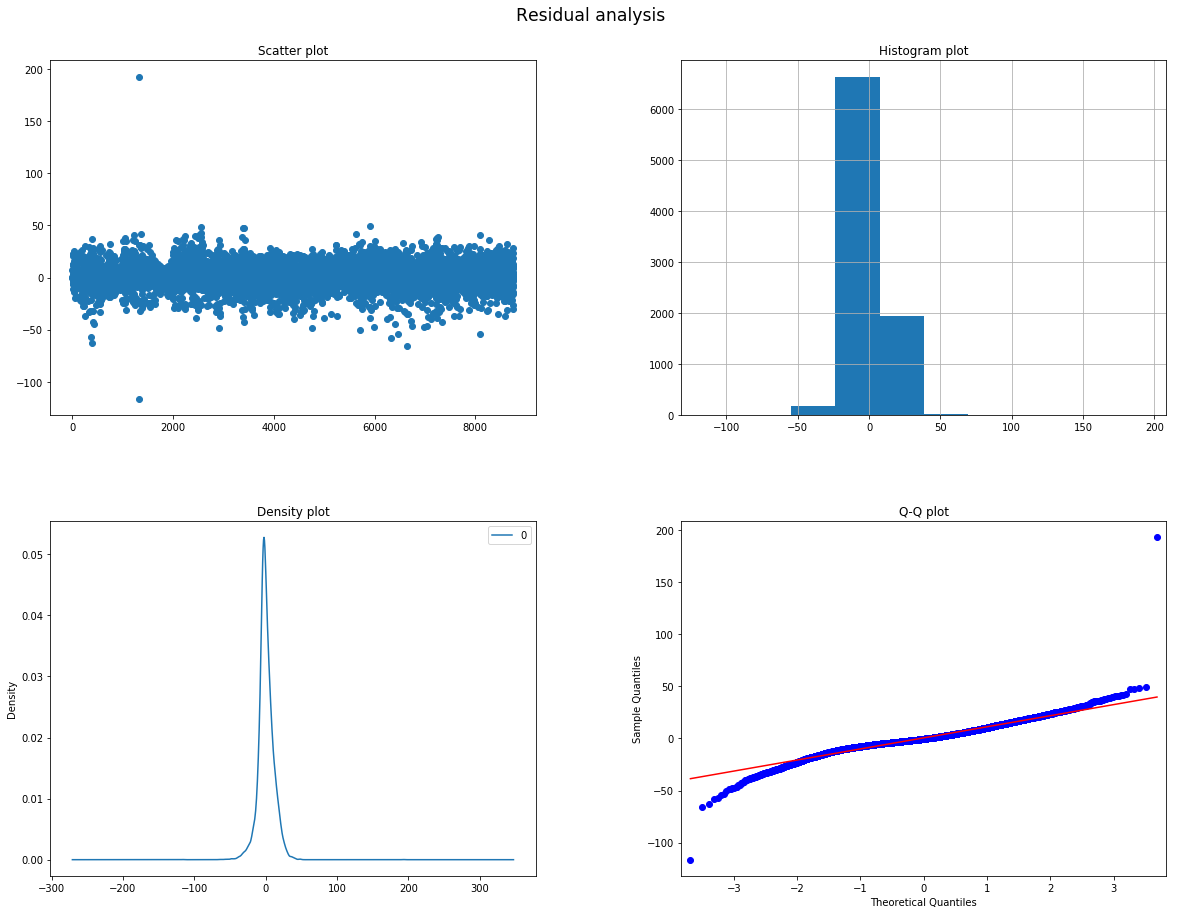

In [55]:
residuals_analysis(residuals_lr2)

In [58]:
# qqplot() input data should be 1D array like. 
res_qq = np.array(oneDArray(residuals_lr2.values))
# The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution.
from scipy import stats
stats.shapiro(res_qq)   # returns(w: The test statistic., p-values)  

(0.9433940052986145, 0.0)

In [59]:
#Perform the Kolmogorov-Smirnov test for goodness of fit.
#This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x).
# Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’. The KS test is only valid for continuous distributions.
stats.kstest(res_qq, 'norm')

KstestResult(statistic=0.3903329518766951, pvalue=0.0)

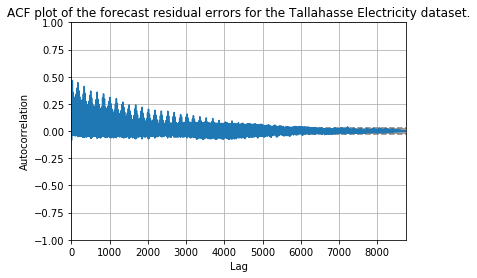

In [61]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(residuals_lr2)
plt.title('ACF plot of the forecast residual errors for the Tallahasse Electricity dataset.')
plt.show()

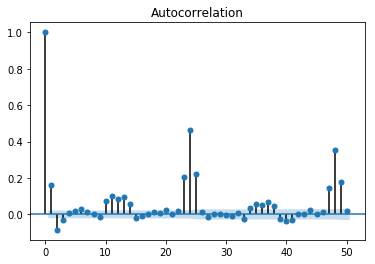

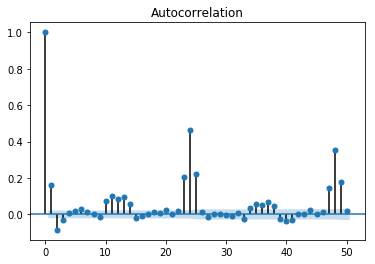

In [60]:
plot_acf(residuals_lr2, lags = 50)

## The Random Forest Regressor Model is suffering overfitting. Since it performs still best. We will try to tune some parameters.

In [39]:
### Random Forest Regressor ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('randomforest', RandomForestRegressor(n_estimators = 200, n_jobs = -1,random_state =1))]

model_rf1 = Pipeline(steps)

# Fit to the training set
model_rf1.fit(X_train_3, y_train_3)

# Evaluate model
evaluate_ml(model_rf1, X_train_3, y_train_3, X_test_3, y_test_3, 1, 'Random Forest Regressor')

Random Forest Regressor
TRAIN : t+1 RMSE: 3.7013 ,TEST : t+1 RMSE: 9.5498
---------------------


(3.70134798983778, 9.549829259643383)

In [40]:
#use inbuilt class feature_importances of tree based classifiers
print(model_rf1[1].feature_importances_)

[1.92590069e-02 9.46762773e-01 2.27373343e-02 1.40513700e-06
 4.13424042e-04 9.01735209e-04 3.48881950e-04 5.58291375e-03
 2.30830138e-03 1.34508223e-03 3.39142454e-04]


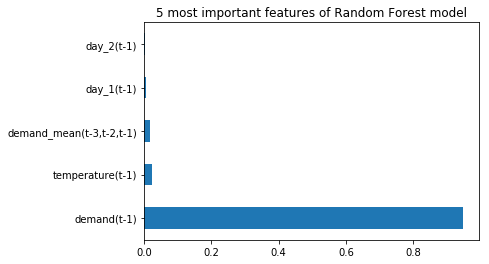

In [41]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model_rf1[1].feature_importances_, index=tal_multi.columns[:-1])
feat_importances.nlargest(5).plot(kind='barh')
plt.title("5 most important features of Random Forest model")
plt.show()

In [42]:
from sklearn.model_selection import GridSearchCV
rfc = RandomForestRegressor(n_jobs = -1, n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 500],   # The number of trees in the forest.
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid,cv=None)
CV_rfc.fit(X_train_3, y_train_3)
print(CV_rfc.best_params_)

{'max_features': 'auto', 'n_estimators': 500}


In [43]:
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('randomforest', RandomForestRegressor(n_estimators = 500, n_jobs = -1,random_state =1))]

model_rf1 = Pipeline(steps)

# Fit to the training set
model_rf1.fit(X_train_3, y_train_3)

# Evaluate model
evaluate_ml(model_rf1, X_train_3, y_train_3, X_test_3, y_test_3, 1, 'Random Forest Regressor')

Random Forest Regressor
TRAIN : t+1 RMSE: 3.6880 ,TEST : t+1 RMSE: 9.5366
---------------------


(3.6880182035421125, 9.536615936075282)

In [44]:
yhat_test_rf1 = model_rf1.predict(X_test_3)

#### Residual error analysis

<a id='mt2'></a> 
### 6.3 PART Three: Univariate multisteps forecasts

### Most predictive modeling algorithms will take some number of observations as input and predict a single output value. They cannot be used directly to make a multi-step time series forecast. This applies to most linear, nonlinear, and ensemble machine learning algorithms.

## One approach where machine learning algorithms can be used to make a multi-step time series forecast is to use them recursively.

In [62]:
dataframe.head()

,t-1,t
2015-07-01 02:00:00,225.0,222.0
2015-07-01 03:00:00,222.0,213.0
2015-07-01 04:00:00,213.0,206.0
2015-07-01 05:00:00,206.0,207.0
2015-07-01 06:00:00,207.0,219.0


In [63]:
# first load the data

# split into train and test sets
X = dataframe.values.copy()
n_test = int(365*24*1)
train, test = X[:-n_test], X[-n_test:] 

X_train, y_train = train[:,:1], train[:,1:] 
X_test, y_test = test[:,:1], test[:,1:]

### Linear Regression ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('Linear', LinearRegression())]

model = Pipeline(steps)

# Fit to the training set
model.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Linear',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [64]:
def multistep_model(n_seq, test, model):
    #n_seq= 24   # number of steps we want to predict ahead
    actual = []
    #rmse_tests = []
    yhat_total = []

    test = pd.DataFrame(test,columns = ['t-1','t'])
    
    for t, _ in test.iterrows():
        # copy test to test_local which will change every time
        test_local = test.copy()
        
        # ensure we have enough data for this instance
        if t+n_seq < test_local.shape[0]:
        # predicting n_seq = 24 steps ahead, so true demand is demand at t+24
            actual.append(test_local.at[t+n_seq, "t"])
    
            predictions = []      
            for step in range(1,n_seq+1): 
                # define the input test data, the first test value is from the true dataset.
                X_test_m = test_local.at[t+step-1,"t-1"].reshape(1,-1)

                # make prediction of test input data 
                predict_next= model.predict(X_test_m)
            
                # update the next test data with the predicted value
                test_local.at[t+step, "t-1"] =  predict_next
        
                # add to the predictions list for this n_seq 
                predictions.append(predict_next)
            
            # the last prediction for step 24 is what we are after
            yhat = predictions[n_seq-1]
        
            # add to the yhat_total list. This is all we have predicted for the next 24 steps.
            yhat_total.append(yhat) 
        
    # convert list of 2d arrays to 1d list
    yhat_total =oneDArray(oneDArray(yhat_total))
    
    rmse_test = np.sqrt(mean_squared_error(actual, yhat_total))
    print('Test: RMSE: t+%d: %f' %(n_seq,rmse_test))
    return actual, yhat_total, rmse_test

In [65]:
actual24, yhat_total24, rmse_24 = multistep_model(24, test, model)

Test: RMSE: t+24: 53.832218


In [66]:
actual1, yhat_total1, rmse_1 = multistep_model(1, test, model)

Test: RMSE: t+1: 37.377925


In [255]:
np.sqrt(mean_squared_error(actual24,yhat_total24))

53.83221843212524

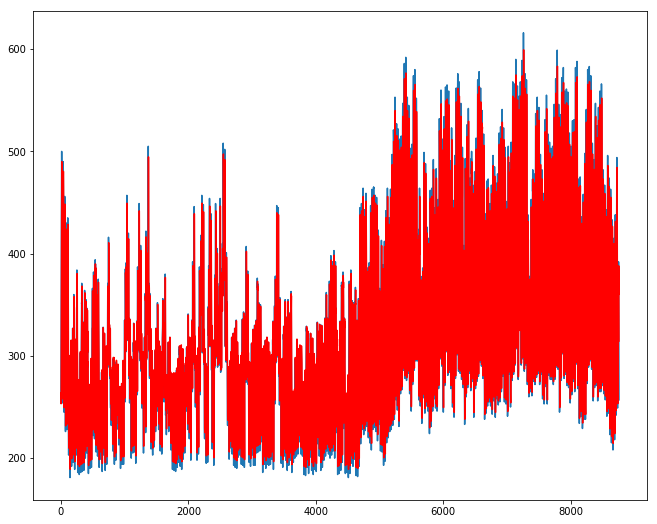

In [249]:
rcParams['figure.figsize'] = 11, 9
plt.plot(actual1,label='actual')
plt.plot(yhat_total1, color='red',label='prediction')

In [192]:
np.sqrt(mean_squared_error(actual, yhat_total))

53.83221843212524

In [290]:
np.sqrt(mean_squared_error(actual24[:100],yhat_total24[:100]))

43.20999401381205

In [180]:
len(actual)

8758

In [181]:
len(yhat_total)

8758

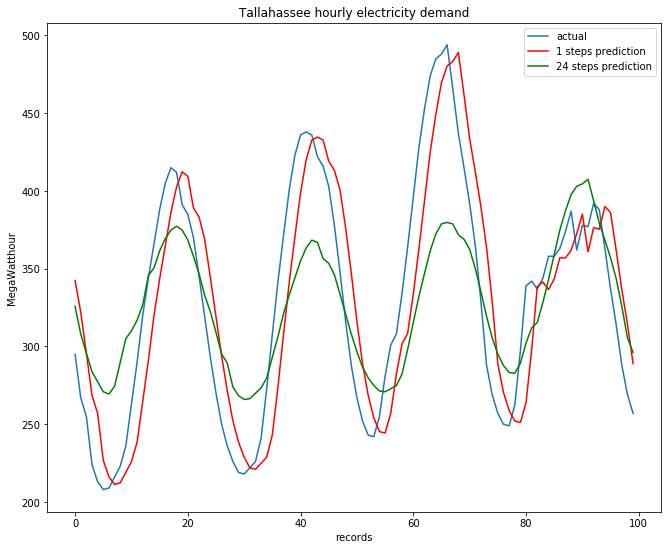

In [67]:
rcParams['figure.figsize'] = 11, 9   # Dynamic rc settings
plt.plot(actual1[-100:],label='actual')  # to ensure each steps start at the same point.
plt.plot(yhat_total1[-100:], color='red',label='1 steps prediction')
plt.plot(yhat_total24[-100:], color='green',label='24 steps prediction')
plt.xlabel('records')
plt.ylabel('MegaWatthour')
plt.title('Tallahassee hourly electricity demand')
plt.legend()
plt.show()

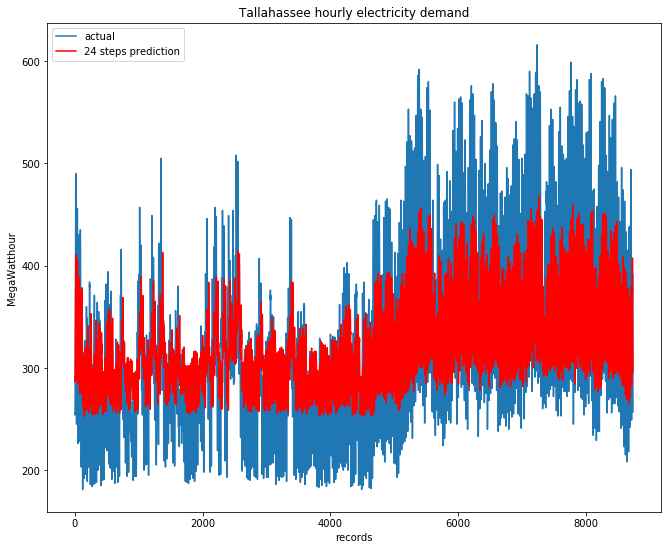

In [258]:
rcParams['figure.figsize'] = 11, 9   # Dynamic rc settings
plt.plot(actual24,label='actual')
plt.plot(yhat_total24, color='red',label='24 steps prediction')
plt.xlabel('records')
plt.ylabel('MegaWatthour')
plt.title('Tallahassee hourly electricity demand')
plt.legend()
plt.show()

In [269]:
# calculate residuals
residuals_1 = [actual1[i]-yhat_total1[i] for i in range(len(yhat_total1))] 
residuals_1 = pd.DataFrame(residuals_1)

In [270]:
residuals_1.describe()

,0
count,8759.000000
mean,0.131612
std,37.379827
min,-133.923934
25%,-28.328983
50%,-1.407193
75%,26.343560
max,126.177927


In [277]:
residuals_1.idxmax()

0    1332
dtype: int64

In [279]:
residuals_1.iloc[1332]

0    126.177927
Name: 1332, dtype: float64

In [261]:
# calculate residuals
residuals_24 = [actual24[i]-yhat_total24[i] for i in range(len(yhat_total24))] 
residuals_24 = pd.DataFrame(residuals_24)

In [282]:
residuals_24.head()

,0
0,-35.680779
1,-33.225811
2,-21.235818
3,6.814217
4,13.974330


In [264]:
residuals_24.describe()

,0
count,8736.000000
mean,2.142634
std,53.792640
min,-118.565346
25%,-37.406748
50%,-8.330532
75%,34.518551
max,177.945014


In [268]:
np.sqrt(np.sum(residuals_24**2)/8726)

0    53.863055
dtype: float64

## The linear regression model works pretty bad in multi-step forecasting.  We will try other models as well.

In [305]:
# first load the data

# split into train and test sets
X = dataframe.values.copy()
n_test = int(365*24*1)
train, test = X[:-n_test], X[-n_test:] 

X_train, y_train = train[:,:1], train[:,1:] 
X_test, y_test = test[:,:1], test[:,1:]

### Linear Regression ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('Linear', RandomForestRegressor())]

model = Pipeline(steps)

# Fit to the training set
model.fit(X_train, y_train)



Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Linear',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [109]:
def multistep_model2(n_seq, test, model):
    #n_seq= 24   # number of steps we want to predict ahead
    actual = []
    #rmse_tests = []
    yhat_total = []

    test = pd.DataFrame(test,columns = ['t-1','t'])
    
    for t, _ in test.iterrows():
        # copy test to test_local which will change every time
        test_local = test.copy()
        
        # ensure we have enough data for this instance
        if t+n_seq < test_local.shape[0]:
        # predicting n_seq = 24 steps ahead, so true demand is demand at t+24
            actual.append(test_local.at[t+n_seq, "t"])
    
            predictions = []      
            for step in range(1,n_seq+1): 
                # define the input test data, the first test value is from the true dataset.
                X_test_m = test_local.at[t+step-1,"t-1"].reshape(1,-1)

                # make prediction of test input data 
                predict_next= model.predict(X_test_m)
            
                # update the next test data with the predicted value
                test_local.at[t+step, "t-1"] =  predict_next
        
                # add to the predictions list for this n_seq 
                predictions.append(predict_next)
            
            # the last prediction for step 24 is what we are after
            yhat = predictions[n_seq-1]
        
            # add to the yhat_total list. This is all we have predicted for the next 24 steps.
            yhat_total.append(yhat) 
        
    # convert list of 2d arrays to 1d list
    yhat_total =oneDArray(yhat_total)
    
    rmse_test = np.sqrt(mean_squared_error(actual, yhat_total))
    print('Test: RMSE: t+%d: %f' %(n_seq,rmse_test))
    return actual, yhat_total, rmse_test

## use differenced data as input 

In [115]:
X = dataframe.diff(24).dropna().copy()

n_test = int(365*24*1)
train, test = X[:-n_test], X[-n_test:] 

X_train, y_train = train.iloc[:,:1], train.iloc[:,1:] 
X_test, y_test = test.iloc[:,:1], test.iloc[:,1:]

### Linear Regression ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('Linear', RandomForestRegressor())]

model = Pipeline(steps)

# Fit to the training set
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('Linear',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [117]:
def multistep_model_diff(n_seq, test, model):
    #n_seq= 24   # number of steps we want to predict ahead
    actual = []
    #rmse_tests = []
    yhat_total = []

  #  test = pd.DataFrame(test,columns = ['t-1','t'])
    # reset the index
    test = test.reset_index(drop=True)

    for t, _ in test.iterrows():
        # copy test to test_local which will change every time
        test_local = test.copy()
        
        # ensure we have enough data for this instance
        if t+n_seq < test_local.shape[0]:
        # predicting n_seq = 24 steps ahead, so true demand is demand at t+24
            actual.append(test_local.at[t+n_seq, "t"])
    
            predictions = []      
            for step in range(1,n_seq+1): 
                # define the input test data, the first test value is from the true dataset.
                X_test_m = test_local.at[t+step-1,"t-1"].reshape(1,-1)

                # make prediction of test input data 
                predict_next= model.predict(X_test_m)
            
                # update the next test data with the predicted value
                test_local.at[t+step, "t-1"] =  predict_next
        
                # add to the predictions list for this n_seq 
                predictions.append(predict_next)
            
            # the last prediction for step 24 is what we are after
            yhat = predictions[n_seq-1]
        
            # add to the yhat_total list. This is all we have predicted for the next 24 steps.
            yhat_total.append(yhat) 
        
    # convert list of 2d arrays to 1d list
    yhat_total =oneDArray(yhat_total)
    
    rmse_test = np.sqrt(mean_squared_error(actual, yhat_total))
    print('Test: RMSE: t+%d: %f' %(n_seq,rmse_test))
    return actual, yhat_total, rmse_test

In [118]:
actual24, yhat_total24, rmse_24 = multistep_model_diff(24, test, model)

Test: RMSE: t+24: 45.238693


In [119]:
### Random Forest Regressor ###
# Create the model pipeline
steps = [('scaler', MinMaxScaler(feature_range=(0, 1))),
         ('randomforest', RandomForestRegressor(n_estimators = 200, n_jobs = -1,random_state =1))]

model_rf24 = Pipeline(steps)

# Fit to the training set
model_rf24.fit(X_train, y_train)


Pipeline(memory=None,
         steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('randomforest',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=200, n_jobs=-1,
                                       oob_score=False, random_state=1,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
_, _, rmse_rf24 = multistep_model_diff(24, test, model_rf24)

In [88]:
rmse_test =[]
for n_seq in range(1,25):
    act, yhat, rmse =  multistep_model_diff(n_seq, test, model)
    rmse_test.append(rmse)

Test: RMSE: t+1: 17.834483
Test: RMSE: t+2: 22.749222
Test: RMSE: t+3: 26.439994
Test: RMSE: t+4: 29.245664
Test: RMSE: t+5: 31.425054
Test: RMSE: t+6: 33.253891
Test: RMSE: t+7: 34.698035
Test: RMSE: t+8: 35.817929
Test: RMSE: t+9: 36.757266
Test: RMSE: t+10: 37.632473
Test: RMSE: t+11: 38.481734
Test: RMSE: t+12: 39.314629
Test: RMSE: t+13: 40.117140
Test: RMSE: t+14: 40.803281
Test: RMSE: t+15: 41.444856
Test: RMSE: t+16: 42.002971
Test: RMSE: t+17: 42.574555
Test: RMSE: t+18: 43.133952
Test: RMSE: t+19: 43.719344
Test: RMSE: t+20: 44.408311
Test: RMSE: t+21: 45.151260
Test: RMSE: t+22: 45.923120
Test: RMSE: t+23: 46.679901
Test: RMSE: t+24: 46.790449


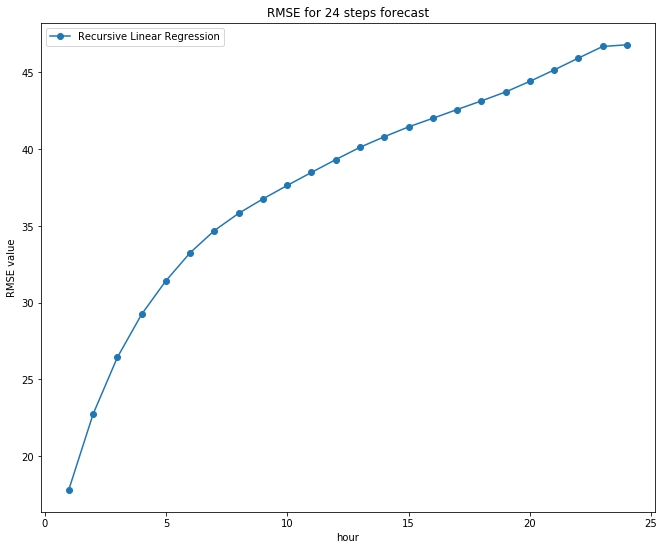

In [89]:
hours = list(range(1,25)) 
plt.plot(hours, rmse_test,  marker='o',label='Recursive Linear Regression')
#plt.plot(hours, rmse_nf_m,  marker='^', label= 'Baseline')
plt.title("RMSE for 24 steps forecast")
plt.xlabel("hour")
plt.ylabel("RMSE value")
plt.legend()
plt.show()

In [81]:
actual24, yhat_total24, rmse_24 = multistep_model_diff(24, test, model)

Test: RMSE: t+24: 46.790449


### Test: RMSE: t+2: 22.749222
Test: RMSE: t+10: 37.632473

In [ ]:
inverted = list()
for i in range(len(forecasts)):
    # create array from forecast
    forecast = array(forecasts[i])
    forecast = forecast.reshape(1, len(forecast))
    # invert differencing
    index = len(X) - n_test + i - 1
    last_ob = series.values[index]
    inv_diff = inverse_difference(last_ob, inv_scale)

In [75]:
actual[:5]

[29.0, 36.0, 34.0, 32.0, 24.0]

In [76]:
yhat_total[:5]

[31.00122514881077,
 24.792952080436223,
 26.237689612256894,
 26.237689612256894,
 31.57471006199257]

In [ ]:
rcParams['figure.figsize'] = 11, 9   # Dynamic rc settings
plt.plot(actual2[8:],label='actual')  # to ensure each steps start at the same point.
plt.plot(yhat_total2[8:], color='red',label='2 steps prediction')
plt.plot(yhat_total10, color='green',label='10 steps prediction')
plt.xlabel('records')
plt.ylabel('MegaWatthour')
plt.title('Tallahassee hourly electricity demand')
plt.legend()
plt.show()

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)
 

In [73]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

[31.00122514881077,
 24.792952080436223,
 26.237689612256894,
 26.237689612256894,
 31.57471006199257,
 31.00122514881077,
 26.835532967061283,
 21.661887351324935,
 25.011475578569232,
 25.011475578569232,
 25.011475578569232,
 25.139017878455725,
 25.139017878455725,
 25.011475578569232,
 20.746423071131343,
 20.746423071131343,
 16.541431515056267,
 14.984248933973168,
 14.167252565330426,
 14.984248933973168,
 14.167252565330426,
 12.091138940747346,
 8.557567660695753,
 10.271122062352173,
 6.945067146271164,
 5.158806629700453,
 5.158806629700453,
 6.183125799355795,
 6.945067146271164,
 10.877447120078227,
 8.557567660695753,
 6.945067146271164,
 -9.222186869242362,
 -18.060061930751978,
 -12.939403166271395,
 -9.029076638877935,
 -9.029076638877935,
 -9.029076638877935,
 -9.029076638877935,
 -9.029076638877935,
 -6.336033257132354,
 -4.862856096074539,
 -4.862856096074539,
 1.725392369278083,
 2.8157184171610745,
 1.725392369278083,
 2.8157184171610745,
 1.6012171961976018,
 -1

In [69]:
# create the simple dictionary of rmses of different models
dict = {'Baseline Naive Forecast (1 feature)':19.962, 
        'Linear Regression (1 feature)':19.8403,
        'Linear Regression (10 features)':10.9564,
        'Gradient Boosting Regressor (1 feature)':19.9003,
        'Gradient Boosting Regressor (10 features)':12.1293,
        'Random Forest (1 feature)':19.9933,
        'Random Forest (10 features)':9.5366}

In [96]:
df = pd.DataFrame(list(dict.items()))
df.columns =["Model","RMSE"]
print (df)
# sort df by Count column
df = df.sort_values(['RMSE']).reset_index(drop=True)
print (df)

                                       Model     RMSE
0        Baseline Naive Forecast (1 feature)  19.9620
1              Linear Regression (1 feature)  19.8403
2            Linear Regression (10 features)  10.9564
3    Gradient Boosting Regressor (1 feature)  19.9003
4  Gradient Boosting Regressor (10 features)  12.1293
5                  Random Forest (1 feature)  19.9933
6                Random Forest (10 features)   9.5366
                                       Model     RMSE
0                Random Forest (10 features)   9.5366
1            Linear Regression (10 features)  10.9564
2  Gradient Boosting Regressor (10 features)  12.1293
3              Linear Regression (1 feature)  19.8403
4    Gradient Boosting Regressor (1 feature)  19.9003
5        Baseline Naive Forecast (1 feature)  19.9620
6                  Random Forest (1 feature)  19.9933


In [107]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = p.get_width()
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


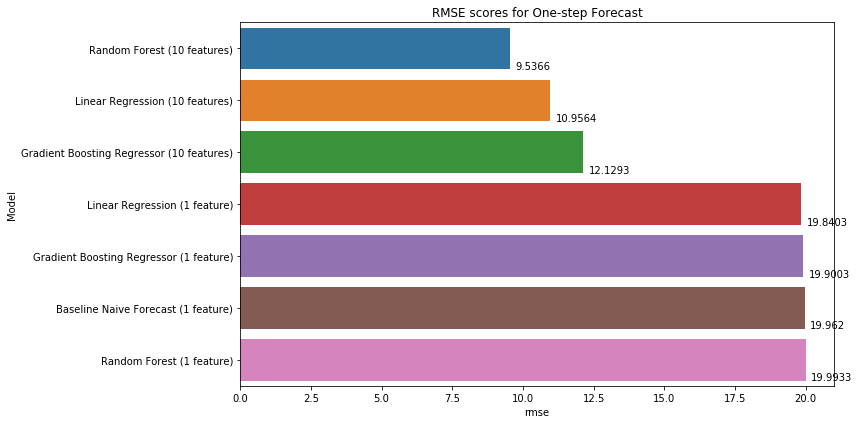

In [112]:
plt.figure(figsize = (12,6))
# plot barh chart with index as x values
ax = sns.barplot(x =df.RMSE , y = df.Model)
#ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="rmse", ylabel='Model')

show_values_on_bars(ax, "h", 0.2)
plt.title("RMSE scores for One-step Forecast")
plt.tight_layout()
plt.show()


In [113]:
# create the simple dictionary of rmses of different models
dict1 = {'Government baseline': 17.616,
        'Baseline Naive Forecast (1 feature)':36.9188, 
        'Linear Regression (1 feature)':45.2387,
        }

In [116]:
df1 = pd.DataFrame(list(dict1.items()))
df1.columns =["Model","RMSE"]

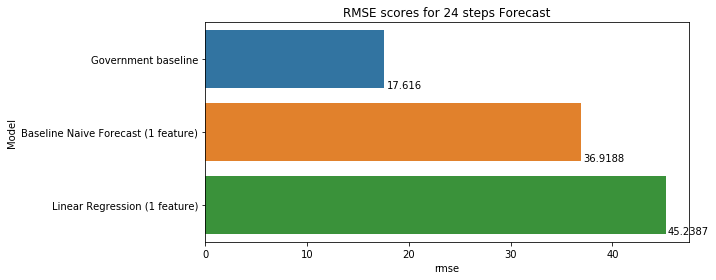

In [119]:
plt.figure(figsize = (10,4))
# plot barh chart with index as x values
ax = sns.barplot(x =df1.RMSE , y = df1.Model)
#ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.set(xlabel="rmse", ylabel='Model')

show_values_on_bars(ax, "h", 0.2)
plt.title("RMSE scores for 24 steps Forecast")
plt.tight_layout()
plt.show()

